In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

from causalnex.structure import StructureModel
import networkx as nx

# PyTorchのDAGを使う
from causalnex.structure.pytorch import from_pandas

from causalnex.network import BayesianNetwork
from causalnex.discretiser import Discretiser
from causalnex.evaluation import classification_report
from causalnex.evaluation import roc_auc
from causalnex.inference import InferenceEngine
from sklearn.model_selection import train_test_split

# original package
from lab_tools.pickle_manage import *

import warnings
warnings.simplefilter('ignore')

# データ読み込みから前処理

In [13]:
df = pd.read_excel('bn/data/230828_230904_AI用qPCRデータ.xlsx', index_col=0, header=1)
df = df.dropna()
df = df.reset_index(drop=True)
df

,glk,agp,yihX,pgm,ptsG,malx,crr,galM,yihR,yeaD,pgi,ascF,chbF,ascB,bglA,bglB,yggF,glpX,fbp,pfkB,pfkA,fbaB,fbaA,tpiA,gapA,pgk,gpmA,ytjc,gpmM,eno,pykF,pykA,ppsA
0,0.000004,2.982088e-05,0.000004,1.512045e-05,0.000015,9.403729e-07,0.000122,0.000015,4.792578e-07,0.000007,0.000029,1.842627e-06,4.533360e-07,1.829236e-06,0.000008,2.389907e-07,9.540312e-07,0.000004,0.000015,0.000015,5.702594e-08,0.000124,0.000124,0.000008,0.000121,1.193258e-07,0.000119,0.000004,0.000008,0.000015,0.000030,0.000015,0.000030
1,0.000008,3.062644e-05,0.000016,2.940716e-08,0.000015,3.847846e-06,0.000124,0.000015,3.848767e-06,0.000015,0.000062,3.815250e-06,1.920287e-06,7.686338e-06,0.000004,3.838396e-06,3.870689e-06,0.000015,0.000031,0.000015,6.161000e-05,0.000062,0.000123,0.000015,0.000123,2.377373e-07,0.000123,0.000008,0.000016,0.000031,0.000061,0.000031,0.000061
2,0.000008,7.608227e-06,0.000016,1.396326e-08,0.000031,9.615077e-07,0.000245,0.000015,4.864569e-07,0.000031,0.000063,9.581183e-07,4.830404e-07,1.953374e-06,0.000004,4.884611e-07,1.951800e-06,0.000008,0.000031,0.000031,6.303937e-05,0.000126,0.000248,0.000015,0.000122,9.666787e-07,0.000122,0.000008,0.000016,0.000062,0.000062,0.000031,0.000062
3,0.000004,1.513944e-05,0.000015,1.225795e-07,0.000015,4.807837e-07,0.000124,0.000015,1.207673e-07,0.000008,0.000031,4.799480e-07,2.398760e-07,9.663095e-07,0.000002,1.217226e-07,4.850537e-07,0.000004,0.000015,0.000015,3.249135e-05,0.000126,0.000123,0.000015,0.000061,2.410427e-07,0.000061,0.000004,0.000008,0.000031,0.000062,0.000031,0.000062
4,0.000008,4.768491e-07,0.000031,6.105349e-08,0.000031,9.593193e-07,0.000124,0.000015,2.428970e-07,0.000016,0.000063,9.566899e-07,4.823107e-07,1.939731e-06,0.000004,2.417564e-07,9.672201e-07,0.000008,0.000031,0.000015,3.260044e-05,0.000127,0.000124,0.000016,0.000124,4.795912e-07,0.000124,0.000008,0.000008,0.000031,0.000062,0.000031,0.000062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.000008,3.070106e-05,0.000016,1.535654e-05,0.000031,3.839581e-06,0.000124,0.000015,1.925948e-06,0.000031,0.000062,1.917541e-06,1.925744e-06,3.847757e-06,0.000004,1.936482e-06,1.930766e-06,0.000008,0.000031,0.000008,3.171622e-05,0.000063,0.000246,0.000031,0.000247,1.227872e-04,0.000061,0.000008,0.000015,0.000122,0.000062,0.000062,0.000123
127,0.000008,3.099429e-05,0.000031,3.081146e-05,0.000032,7.695749e-06,0.000124,0.000015,3.854014e-06,0.000015,0.000062,1.911347e-06,1.917208e-06,3.847905e-06,0.000004,3.842958e-06,3.857945e-06,0.000016,0.000031,0.000008,3.202456e-05,0.000062,0.000123,0.000031,0.000124,6.113619e-05,0.000061,0.000008,0.000008,0.000124,0.000031,0.000031,0.000061
128,0.000015,3.061766e-05,0.000063,3.095131e-05,0.000063,7.836547e-06,0.000249,0.000031,3.893389e-06,0.000063,0.000124,1.914530e-06,1.920315e-06,7.770304e-06,0.000008,3.884772e-06,3.894949e-06,0.000016,0.000062,0.000015,6.359008e-05,0.000124,0.000245,0.000031,0.000247,2.488283e-04,0.000122,0.000015,0.000015,0.000248,0.000122,0.000062,0.000123
129,0.000015,3.050630e-05,0.000031,7.612714e-06,0.000031,1.893243e-06,0.000122,0.000015,9.572219e-07,0.000008,0.000031,9.523104e-07,4.757393e-07,1.892085e-06,0.000004,9.569714e-07,9.569967e-07,0.000004,0.000015,0.000007,3.189402e-05,0.000248,0.000061,0.000015,0.000061,6.136734e-05,0.000061,0.000008,0.000004,0.000061,0.000061,0.000030,0.000031


In [3]:
# # qcutをする
# df_discrete = df.copy()

# for i in range(len(df_discrete.columns)):
#     df_discrete.iloc[:, i] = pd.qcut(df_discrete.iloc[:, i], 4)
#     # contingency_table = pd.crosstab(df_new[])

# df_discrete

In [4]:
# # qcutをしたデータに対してラベルエンコーディング
# struct_data = df_discrete.copy()

# le = LabelEncoder()
# for col in struct_data.columns:
#     struct_data[col] = le.fit_transform(struct_data[col])

# struct_data

# 構造学習

In [28]:
# 構造学習
dist_type_schema = {c:"cont" for c in df.columns}

# data typeを加味してpytorchを用いて推定
sm_pytorch = from_pandas(
    df, 
    dist_type_schema = dist_type_schema, 
    hidden_layer_units = None,
    lasso_beta = 0,  # L1
    ridge_beta = 0 , # L2
    w_threshold = 0.,  # edge_weight閾値
    use_bias = False
)
# sm_pytorch.threshold_till_dag()
# sm_pytorch.remove_edges_below_threshold(0.1) # 

# weights print
# nx_util.print_weights(sm_pytorch)

# plot sturecture model
# nx_util.plot_structure_model(sm_pytorch, layout_method="shell", layout_seed=1, figsize=(5,5))

In [24]:
sm_pytorch.nodes

NodeView(('glk', 'agp', 'yihX', 'pgm', 'ptsG', 'malx', 'crr', 'galM', 'yihR', 'yeaD', 'pgi', 'ascF', 'chbF', 'ascB', 'bglA', 'bglB', 'yggF', 'glpX', 'fbp', 'pfkB', 'pfkA', 'fbaB', 'fbaA', 'tpiA', 'gapA', 'pgk', 'gpmA', 'ytjc', 'gpmM', 'eno', 'pykF', 'pykA', 'ppsA'))

In [20]:
edge_width = [ d["weight"]*1 for (u, v, d) in sm_pytorch.edges(data=True)]
sm_l = sm_pytorch.get_largest_subgraph()

In [22]:
sm_l

[]

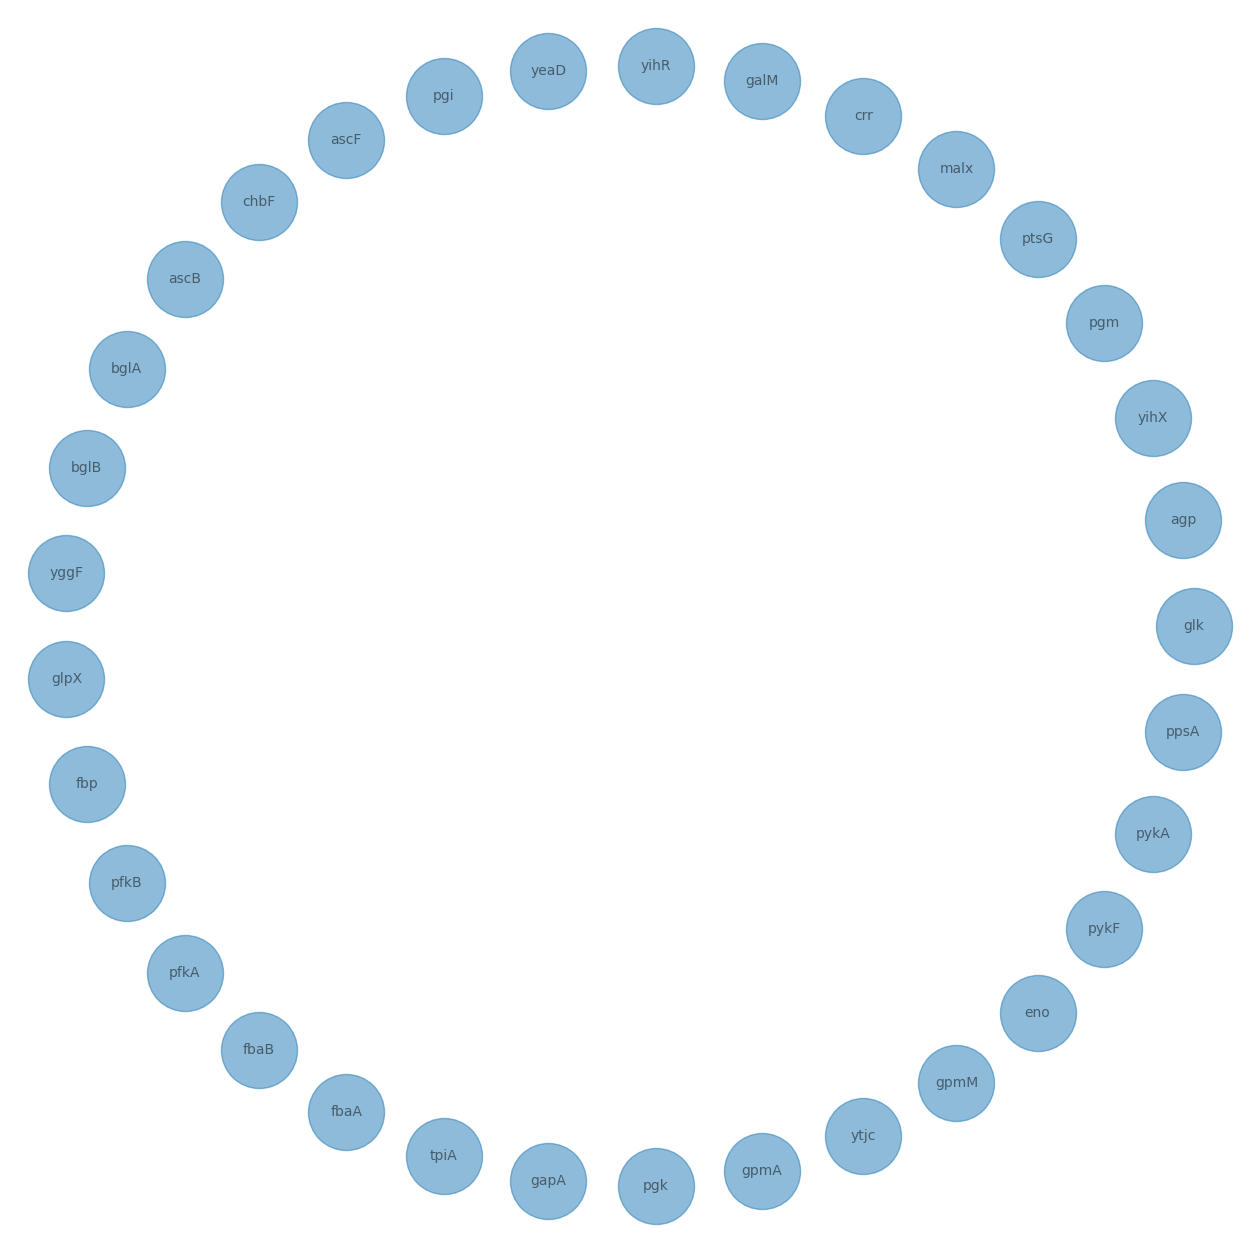

In [26]:
# ネットワーク図を描画
fig, ax = plt.subplots(figsize=(16,16))
nx.draw_circular(sm_pytorch,
                 with_labels=True,
                 font_size=10,
                 node_size=3000,
                 arrowsize=20,
                 alpha=0.5,
                 ax=ax)
plt.plot()

In [75]:
# オブジェクトを保存
output_object(sm, "sm.pickle", "./")

[]

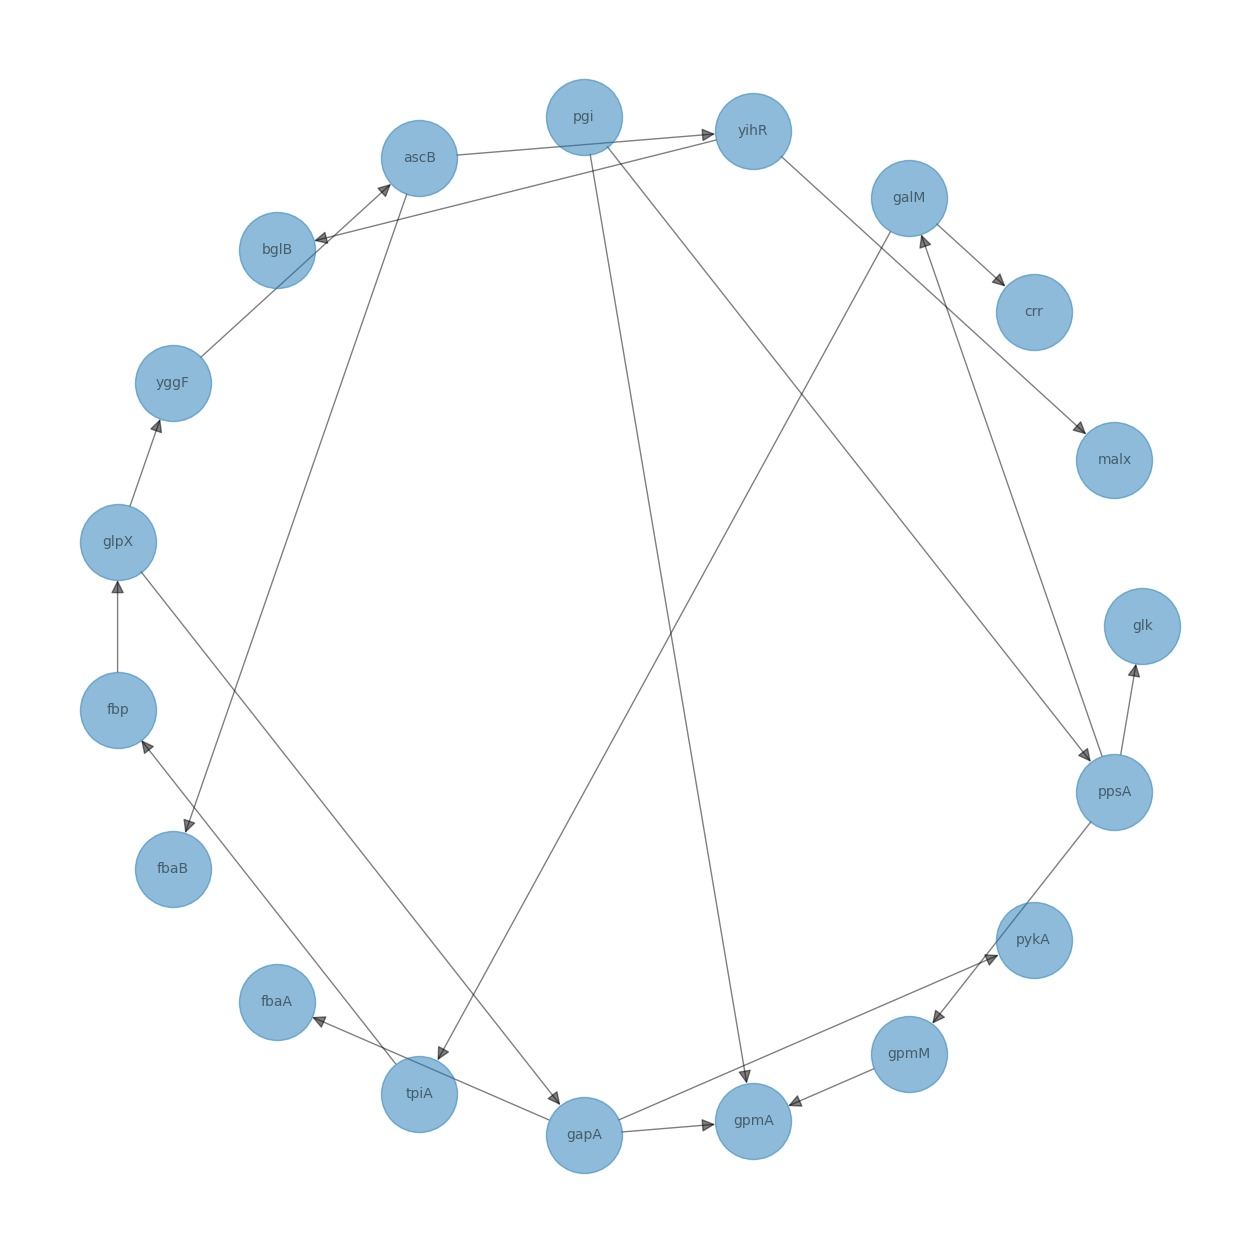

In [76]:
# 閾値を設定し、残すエッジを決める
sm.remove_edges_below_threshold(0.4)

# エッジが伸びてないノードを消す
edge_width = [ d["weight"]*1 for (u, v, d) in sm.edges(data=True)]
sm_l = sm.get_largest_subgraph()

# ネットワーク図を描画
fig, ax = plt.subplots(figsize=(16,16))
nx.draw_circular(sm_l,
                 with_labels=True,
                 font_size=10,
                 node_size=3000,
                 arrowsize=20,
                 alpha=0.5,
                 ax=ax)
plt.plot()

# ベイジアンネットワーク

In [48]:
bn = BayesianNetwork(sm_l)

## 離散化処理

In [49]:
# DAGに存在しているノードのみのデータフレームを作成
discretised_data = struct_data[[x for x in sm_l.nodes]]
# # 列ごとのユニークな値を辞書のValueとして登録
# data_vals = {col: data[col].unique() for col in data.columns}
# # 0: no-failure, 1~3: have-failureとする
# failures_map = {v: "no-failure" if v == [0] else "have-failure" 
#                 for v in data_vals["failures"]}
# # 1~2:short-studytime, 3~4:long-studytimeとする 
# studytime_map = {v: "short-studytime" if v in [1,2] else "long-studytime"
#                  for v in data_vals["studytime"]}
# # 上二つのマッピングを実行
# discretised_data["failures"] = discretised_data["failures"].map(failures_map)
# discretised_data["studytime"] = discretised_data["studytime"].map(studytime_map)

# # 離散化処理を行う
# # uniform: 均一に分割
# # quantile: 分位数で分割
# # fixed: numeric_split_pointsで指定した値で分割
# discretised_data["absences"] = Discretiser(method="fixed",
#                                           numeric_split_points=[1,10]).transform(discretised_data["absences"].values)
# discretised_data["G1"] = Discretiser(method="fixed",
#                           numeric_split_points=[10]).transform(discretised_data["G1"].values)
# discretised_data["G2"] = Discretiser(method="fixed",
#                           numeric_split_points=[10]).transform(discretised_data["G2"].values)
# discretised_data["G3"] = Discretiser(method="fixed",
#                           numeric_split_points=[10]).transform(discretised_data["G3"].values)

# # 離散化したデータをマッピングする
# absences_map = {0: "No-absence", 1:"Low-absence", 2:"High-absence"}
# G1_map = {0: "Fail", 1: "Pass"}
# G2_map = {0: "Fail", 1: "Pass"}
# G3_map = {0: "Fail", 1: "Pass"}
# discretised_data["absences"] = discretised_data["absences"].map(absences_map)
# discretised_data["G1"] = discretised_data["G1"].map(G1_map)
# discretised_data["G2"] = discretised_data["G2"].map(G2_map)
# discretised_data["G3"] = discretised_data["G3"].map(G3_map)

discretised_data

,glk,malx,crr,galM,yihR,pgi,ascB,bglB,yggF,glpX,fbp,fbaB,fbaA,tpiA,gapA,gpmA,gpmM,pykA,ppsA
0,0,0,1,1,1,0,0,0,1,0,0,1,3,0,2,2,1,0,1
1,0,3,2,2,3,2,3,3,3,3,2,0,2,2,2,3,3,2,2
2,0,0,3,1,2,2,1,2,3,2,2,1,3,1,2,2,3,2,2
3,0,0,2,2,0,1,0,0,0,1,0,2,2,1,0,1,1,2,2
4,0,0,2,2,1,2,1,1,1,2,2,2,3,2,2,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0,3,3,2,3,1,2,3,2,2,2,0,3,3,3,1,2,3,3
127,0,3,2,2,3,1,2,3,3,3,3,0,2,3,2,0,1,1,2
128,1,3,3,3,3,3,3,3,3,3,3,0,3,3,3,2,2,3,3
129,1,1,1,1,2,0,0,2,1,0,0,2,0,1,1,1,0,1,1


In [50]:
train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1)

In [51]:
bn = bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(train)

In [52]:
bn.cpds["glk"]

ppsA,0,1,2,3
glk,,,,
0,0.310345,0.166667,0.370370,0.161290
1,0.137931,0.333333,0.148148,0.322581
2,0.379310,0.266667,0.222222,0.225806
3,0.172414,0.233333,0.259259,0.290323


# 評価

In [ ]:
predictions = bn.predict(discretised_data, "glk")
print(discretised_data.loc[1, "glk"])

In [54]:
display(classification_report(bn, test, "glk"))

{'glk_0': {'precision': 0.4,
  'recall': 0.5,
  'f1-score': 0.4444444444444445,
  'support': 4},
 'glk_1': {'precision': 0.4,
  'recall': 0.4,
  'f1-score': 0.4000000000000001,
  'support': 5},
 'glk_2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 'glk_3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5},
 'accuracy': 0.2857142857142857,
 'macro avg': {'precision': 0.2,
  'recall': 0.225,
  'f1-score': 0.21111111111111114,
  'support': 14},
 'weighted avg': {'precision': 0.2571428571428572,
  'recall': 0.2857142857142857,
  'f1-score': 0.2698412698412699,
  'support': 14}}

In [55]:
for n in bn.nodes:
    roc, auc = roc_auc(bn, test, n)
    print(n, auc)

galM 0.7891156462585034
crr 0.7908163265306123
tpiA 0.8231292517006803
yihR 0.8894557823129252
malx 0.8435374149659863
bglB 0.9047619047619047
pgi 0.30952380952380953
gpmA 0.8886054421768708
ppsA 0.641156462585034
ascB 0.7891156462585035
fbaB 0.7576530612244897
yggF 0.8443877551020408
glpX 0.7738095238095237
gapA 0.8333333333333334
fbp 0.8027210884353742
fbaA 0.7414965986394557
pykA 0.9251700680272109
gpmM 0.7210884353741497
glk 0.5153061224489796
